## **2023 CS376 Assignment #4: Image Classification with Convolutional Neural Networks (CNNs)**

In this assignment, you should classify the images in the CIFAR10 dataset into 10 categories using Convolution Neural Networks (CNNs).

- Categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Build a CNN model and take a look at how well it performns as it classifies images in the CIFAR10 dataset.

Train your own CNN model and evaluate the results.

### **PyTorch Documentation**
- You can refer to the PyTorch documentation for your assignment.
- https://pytorch.org/docs/stable/index.html

### **Prerequisite: change the runtime type to GPU**.
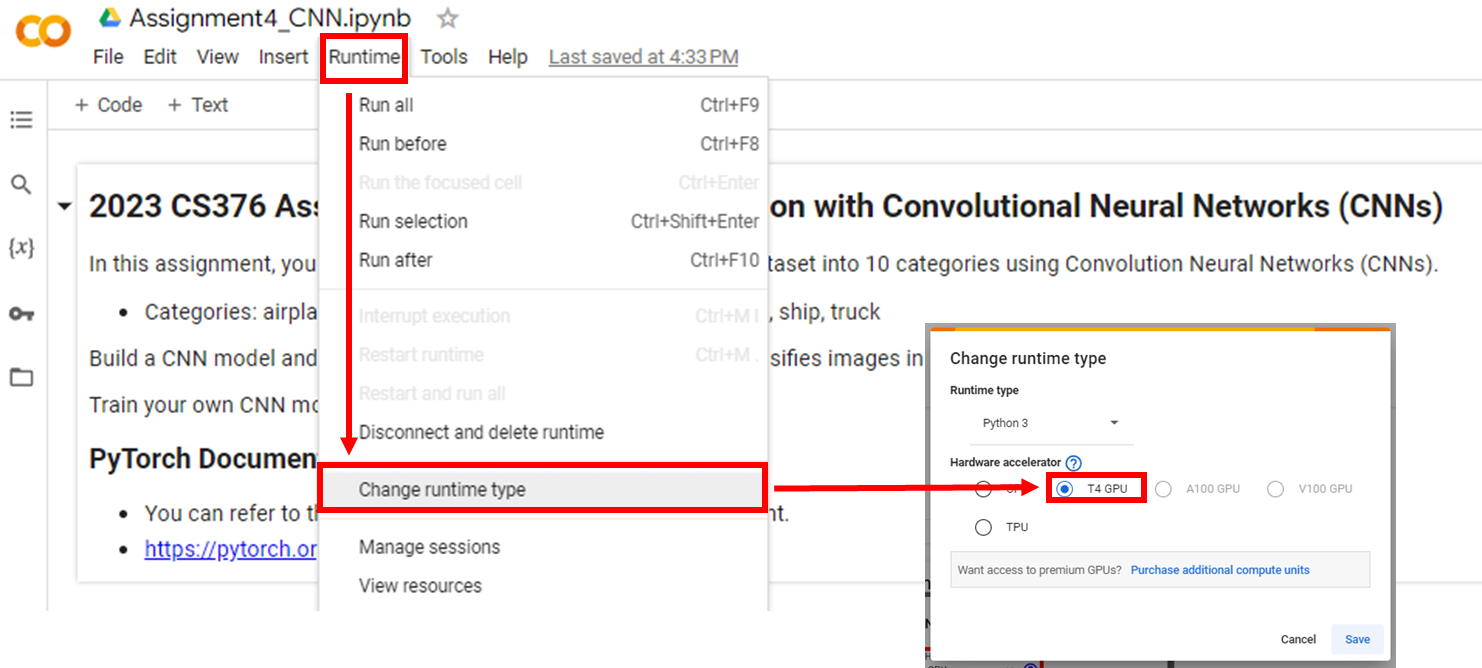


## **Preparation: Packages**
The following code is the preparation for porting packages.

In [31]:
# Import the required packages.
import os
import random

import numpy as  np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt

# Fix the random seed.
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

## **Preparation: Experiment configuration**

In this assignment, the training and optimization hyper-parameters are fixed as below.

In [32]:
# Training & optimization hyper-parameters.
max_epoch = 100
learning_rate = 0.1
batch_size = 512
device = 'cuda'

## **Step 1. Data Pipeline Construction**

**`torchvision.datasets.CIFAR10`** will automatically construct **`CIFAR10`** dataset.

In [33]:
data_dir = "./my_data"

# torchvision.transforms is a module provided by PyTorch for preprocessing and augmenting image data.
transform = transforms.Compose(
    [transforms.ToTensor(), # Transform the data type of images into Tensor.
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) # Normalize images.

# Define the dataset and dataloader.
# torchvision.datasets is a package that aggregates datasets provided by PyTorch.
train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# The classes of the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output_dim = len(classes)

Files already downloaded and verified
Files already downloaded and verified


## **Step 2. Build your Convolutional Neural Networks (CNNs)**

Build your own convolutional neural network layer.

**Do not use** convolutional operations from torch like **nn.Conv2d** or **F.Conv2d**.

- The operations in the tutorial are enough for this step.

In [34]:
# Let's build your own CNN.
class My_Conv2d(nn.Module):
    def __init__(self, in_feature, n_filter, filter_size, stride, pad):
        super(My_Conv2d, self).__init__()
        # Create your own convolutional layer.
        """
        Your convolutional layer will be initialized with

        - in_feature(int): input feature dimension (in_feature(int))
        - n_filter(int): the number of filters (n_filter(int))
        - filter_size(int): the size of filter
        - stride(int): stride
        - pad(int): number of paddings

        For simplicity, we assume that all filters are square filters
        The shape of your filter should be [n_filter x in_feature x filter_size x filter_size]
        """
        ################## IMPLEMENT HERE ##################
        # Define the parameters for CNN.
        self.filter_size = filter_size
        self.in_feature = in_feature
        self.n_filter = n_filter

        # [n_filter x in_feature x filter_size x filter_size]
        self.filters = nn.Parameter(torch.zeros((n_filter, in_feature, filter_size, filter_size), requires_grad=True))
        self.bias = nn.Parameter(torch.zeros((1,n_filter,1,1), requires_grad=True))
        torch.nn.init.xavier_uniform_(self.filters)

        self.stride = stride
        self.pad = pad
        ####################################################

    def forward(self,x):
        # The size of the input will be [n_batch x in_feature x H x W]
        # The size of the output should be [n_batch x n_filter x H' x W']
        # where H', W' are the image size after convolution

        # Calculate the size of feature map after a convolution operation.
        ################## IMPLEMENT HERE ##################
                          ###index 확인###
        new_h = (x.shape[2]-self.filter_size+2*self.pad)//self.stride+1 #convolution 계산 이후의 size 계산 (filter, pad, stride 맞춰서 계산)
        new_w = (x.shape[3]-self.filter_size+2*self.pad)//self.stride+1 #*** //는 나머지 구하는  연산
        ####################################################

        # Add the padding to the input x.
        padded_x = F.pad(x, pad = (self.pad, self.pad, self.pad, self.pad))

        ################## IMPLEMENT HERE ##################
        # Precalculate the strided verison of the padded input.
        strided = torch.as_strided(padded_x, (padded_x.shape[0], padded_x.shape[1], new_h, new_w, self.filter_size, self.filter_size), \
                                   (padded_x.shape[1] * padded_x.shape[2] * padded_x.shape[3], padded_x.shape[2]*padded_x.shape[3],  self.stride * padded_x.shape[3], self.stride, padded_x.shape[3], 1))

        # Calculate the CNN result.
        result_x = torch.tensordot(self.filters, strided, dims=([1,2,3],[1,4,5])).transpose(0,1) + self.bias
        ####################################################
        return result_x

In [35]:
import torch

# 예시 입력 텐서 생성 (2차원)
x = torch.tensor([[1, 2, 3, 4],
                  [5, 6, 7, 8],
                  [9, 10, 11, 12]])

# torch.as_strided를 사용하여 새로운 텐서 생성 (3차원)
strided = torch.as_strided(x, (3, 2, 2), (2, 3, 1))
# (3,2,2) shape을 가지는 tensor를 생성
# 0번째 차원에 대해서 간격 2로 3개 생성
# 1번째 차원에 대해서 간격 3으로 2개 생성
# 2번째 차원에 대해서 간격 1로 2개 생성
# 결과 출력
print(strided)

tensor([[[1, 2],
         [4, 5]],

        [[3, 4],
         [6, 7]],

        [[5, 6],
         [8, 9]]])


In [36]:
# 예시 텐서 생성
a = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([[5, 6], [7, 8]])

# torch.tensordot을 사용하여 텐서곱 계산
result = torch.tensordot(a, b, dims=([1,0],[0,1]))

print(result)

tensor(69)


## **Step 3. Now, build your own CNN model based on My_Conv2d**

You must use **My_Conv2d** for convolutional operations.

You **may use** other functions such as **nn.MaxPool2d** or **nn.Linear**.

Try to create a model that can achieve **80% accuracy or higher** on the test set.

In [37]:
# Let's build your own model.

class MyOwnClassifier(nn.Module):
    def __init__(self):
        super(MyOwnClassifier, self).__init__()
        ################## IMPLEMENT HERE ##################
        # Define your own layers!
        self.conv1 = My_Conv2d(3, 64, 3,1,1)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        self.dropout1 = nn.Dropout()
        self.conv2 = My_Conv2d(64, 128, 3, 1,1)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        self.dropout2 = nn.Dropout()
        self.conv3 = My_Conv2d(128, 256, 3, 1,1)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        self.dropout3 = nn.Dropout()
        self.fcn1 = nn.Linear(256*4*4, 256)
        self.dropout4 = nn.Dropout()
        self.fcn2 = nn.Linear(256, output_dim)
        self.relu = nn.ReLU()
        ####################################################

    def forward(self, x):
        ################## IMPLEMENT HERE ##################
        # Pass the input through the layer.
        x1 = self.dropout1(self.maxpool1(self.relu(self.conv1(x))))
        x2 = self.dropout2(self.maxpool2(self.relu(self.conv2(x1))))
        x3 = self.dropout3(self.maxpool3(self.relu(self.conv3(x2))))
        x4 = self.dropout4(self.relu(self.fcn1(torch.flatten(x3, start_dim=1))))
        output = self.fcn2(x4)
        ####################################################
        return output

## **Step 4. Initialize the network and optimizer**

In [38]:
my_classifier = MyOwnClassifier()
my_classifier = my_classifier.to(device)

# Print the architecture of your convolution neural network.
print(my_classifier)

optimizer = optim.SGD(my_classifier.parameters(), lr=learning_rate)

MyOwnClassifier(
  (conv1): My_Conv2d()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): My_Conv2d()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): My_Conv2d()
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fcn1): Linear(in_features=4096, out_features=256, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fcn2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## **Step 5. Train the network**

In [39]:
train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(max_epoch):
    # Train phase.
    my_classifier.train()
    epoch_loss = 0
    epoch_acc = 0
    n_train = 0
    for inputs, labels in train_dataloader:
        # Load data to with GPU.
        # Send 'inputs' and 'labels' to either cpu or gpu using the 'device' variable.
        inputs = inputs.to(device)
        labels = labels.to(device)
        print(inputs.shape)
        # Feed data into the network and get outputs.
        # Feed `inputs` into the network, get an output, and keep it in a variable called `logits`.
        logits = my_classifier(inputs)

        # Calculate loss.
        # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
        # Compute loss using `logits` and `labels`, and keep it in a variable called `loss`.
        ################## IMPLEMENT HERE ##################
        loss = F.cross_entropy(logits, labels)
        ####################################################

        # Note: You should flush out gradients computed in the previous step before computing gradients in the current step.
        #       Otherwise, gradients will accumulate.

        # Flush out the previously computed gradient.
        # write your code here (one-liner).
        ################## IMPLEMENT HERE ##################
        optimizer.zero_grad()
        ####################################################

        # Backpropagate loss.
        # Backward the computed loss.
        # write your code here (one-liner).
        ################## IMPLEMENT HERE ##################
        loss.backward()
        ####################################################

        # Update the network weights.
        # Write your code here (one-liner).
        ################## IMPLEMENT HERE ##################
        optimizer.step()
        ####################################################

        # Gather loss and accuracy for visualization.
        epoch_loss += loss.item()*inputs.size(0)
        epoch_acc += (logits.argmax(dim=1) == labels).float().sum().item()
        n_train += inputs.size(0)

    # Save losses and accuracies in a list so that we can visualize them later.
    epoch_loss /= n_train
    epoch_acc /= n_train
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)


    # Test phase
    n_test = 0.
    test_loss = 0.
    test_acc = 0.

    my_classifier.eval()
    for test_inputs, test_labels in test_dataloader:
        # Send 'test_inputs' and 'test_labels' to either cpu or gpu using the 'device' variable.
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)

        # Feed `inputs` into the network, get an output, and keep it in a variable called `logits`.
        ################## IMPLEMENT HERE ##################
        logits = my_classifier(test_inputs)
        ####################################################

        # Calculate loss
        # Note: `F.cross_entropy` function receives logits, or pre-softmax outputs, rather than final probability scores.
        # Compute loss using `logits` and `labels`, and keep it in a variable called `tmp_loss`.
        ################## IMPLEMENT HERE ##################
        tmp_loss = F.cross_entropy(logits, test_labels, reduction='sum')
        ####################################################

        # Gather loss and accuracy for visualization.
        test_loss += tmp_loss.item()
        test_acc += (logits.argmax(dim=1) == test_labels).float().sum().item()
        n_test += test_inputs.size(0)

    test_loss /= n_test
    test_acc /= n_test
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print('[epoch:{}] train loss : {:.4f} train accuracy : {:.4f} test_loss : {:.4f} test accuracy : {:.4f}'.format(epoch+1, epoch_loss, epoch_acc, test_loss, test_acc))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.Size([512, 3, 32, 32])
torch.S

## **Step 6. Visualize the loss and accuracy**

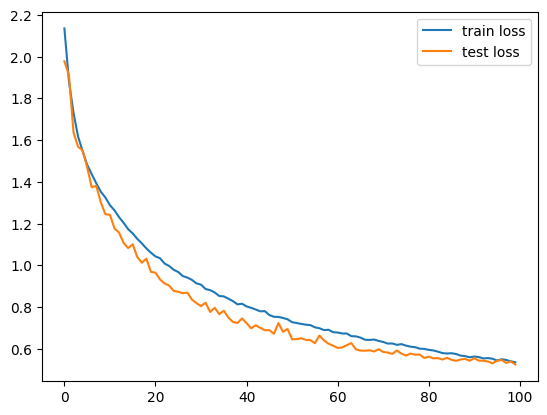

In [40]:
# Visualize the losses for the train and test set.
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

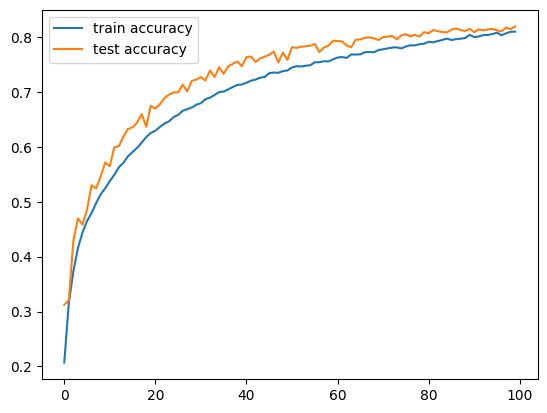

In [41]:
# Visualize the accruacy for the train and test set.
plt.clf()
plt.plot(train_accs, label='train accuracy')
plt.plot(test_accs, label='test accuracy')
plt.legend()
plt.show()

label : cat
prediction : cat


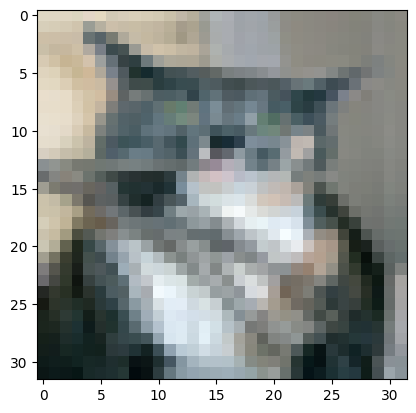

In [42]:
my_classifier.eval()

num_test_samples = len(test_dataset)
random_idx = random.randint(0, num_test_samples)
test_input, test_label = test_dataset.__getitem__(random_idx)
test_prediction = F.softmax(my_classifier(test_input.unsqueeze(0).to(device)), dim=1).argmax().item()
print('label : %s' % classes[test_label])
print('prediction : %s' % classes[test_prediction])

# Functions to show an image
def imshow(img):
    img[0] = img[0] * 0.247 + 0.4914
    img[1] = img[1] * 0.243 + 0.4822
    img[2] = img[2] * 0.261 + 0.4465
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
# Show images
imshow(torchvision.utils.make_grid(test_input))